In [23]:
%load_ext autoreload
%autoreload 2

#%pylab notebook
%matplotlib inline
from pylab import *
from matplotlib import rc;rc('text', usetex=True);rc('font', weight='bold');matplotlib.rcParams['text.latex.preamble'] = r'\boldmath'
import os
rc('text.latex',preamble=r'\usepackage{/Users/sraghunathan/.configs/apjfonts}')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
rcParams['figure.dpi'] = 150
rcParams['font.family'] = 'serif'
rcParams["figure.facecolor"] = 'white'

In [25]:
import argparse, sys, numpy as np, scipy as sc, warnings, os
sys.path.append('/Users/sraghunathan/Research/SPTPol/analysis/git/DRAFT/modules/')
import flatsky, misc, exp_specs
import ilc, foregrounds as fg

#import matplotlib.cbook
warnings.filterwarnings('ignore',category=RuntimeWarning)
#warnings.filterwarnings('ignore', category=DeprecationWarning)
#warnings.filterwarnings('ignore', category=matplotlib.cbook.mplDeprecation)

In [26]:
#some constants
h=6.62607004e-34 #Planck constant in m2 kg / s
k_B=1.38064852e-23 #Boltzmann constant in m2 kg s-2 / K-1
Tcmb = 2.73 #Kelvin

In [27]:
#params
paramfile = 'params.ini'

# read and store param dict
param_dict = misc.fn_get_param_dict(paramfile)
el = np.arange(param_dict['lmax'])
include_gal = param_dict['include_gal'] ##1
s4like_mask = param_dict['s4like_mask']
s4like_mask_v2 = param_dict['s4like_mask_v2']
s4like_mask_v3 = param_dict['s4like_mask_v3']
s4delensing_mask = param_dict['s4delensing_mask']
if not include_gal:
    if s4like_mask:
        param_dict['which_gal_mask'] = 3
    elif s4like_mask_v2:
        param_dict['which_gal_mask'] = 2
    elif s4like_mask_v3:
        param_dict['which_gal_mask'] = 0
    elif s4delensing_mask:
        param_dict['which_gal_mask'] = 0
which_gal_mask = param_dict['which_gal_mask']
try:
    remove_atm = param_dict['remove_atm']
except:
    remove_atm = 0

In [28]:
#S4 specs
expname = 's4wide'
#expname = 'cmbhd'
#expname = 's4deep'
#expname = 's4deepv3r025' #20201019
specs_dic, corr_noise_bands, rho, corr_noise = exp_specs.get_exp_specs(expname, remove_atm = remove_atm)
freqarr = sorted( specs_dic.keys() )
nc = len( freqarr )
freqcalib_fac = None
final_comp = 'cmb'
TParr = ['T', 'P']
#which_spec_arr = ['TT', 'EE', 'TE']
which_spec_arr = ['TT', 'EE']
#which_spec_arr = ['TE']
##include_gal = 1
reduce_cib_power = None
total_obs_time = 7. #years
total_obs_time_default = 7. #years
if expname.find('cmbhd')>-1:
    reduce_cib_power = 17. #150 GHz power reduction after removing sources above 0.04 mJy

#cl multipler - multiply a given spectra by some amount to perform partial ILC. similar to https://arxiv.org/abs/2102.05033
cl_multiplier_dic = {}
###cl_multiplier_dic['gal_dust'] = 1.

In [29]:
#beam and noise arr
beamarr = []
noisearr_T, elkneearr_T, alphakneearr_T = [], [], []
noisearr_P, elkneearr_P, alphakneearr_P = [], [], []
for freq in freqarr:
    beam_arcmins, white_noise_T, elknee_T, alphaknee_T, white_noise_P, elknee_P, alphaknee_P = specs_dic[freq]
    if (1): #noise scaling based on total_obs_time
        noise_scaling_fac = (total_obs_time_default / total_obs_time)**0.5
        white_noise_T = white_noise_T * noise_scaling_fac
        white_noise_P = white_noise_P * noise_scaling_fac        
    beamarr.append(beam_arcmins)
    noisearr_T.append(white_noise_T)
    noisearr_P.append(white_noise_P)
    elkneearr_T.append(elknee_T)
    elkneearr_P.append(elknee_P)
    alphakneearr_T.append(alphaknee_T)
    alphakneearr_P.append(alphaknee_P)    

print(elkneearr_T)

[415.0, 391.0, 1932.0, 3917.0, 6740.0, 6792.0]


In [30]:
#collect beam and noise into a dic; elknee and alpha into a dic
beam_noise_dic = {}
elknee_dic = {}
for TP in TParr:
    beam_noise_dic[TP] = {}
    elknee_dic[TP] = {} 
    if TP == 'T':
        freqarr, beamarr, noisearr, elkneearr, alphakneearr = freqarr, beamarr, noisearr_T, elkneearr_T, alphakneearr_T
    elif TP == 'P':
        freqarr, beamarr, noisearr, elkneearr, alphakneearr = freqarr, beamarr, noisearr_P, elkneearr_P, alphakneearr_P

    for (freq, beam, noise, elknee, alphaknee) in zip(freqarr, beamarr, noisearr, elkneearr, alphakneearr):
        beam_noise_dic[TP][freq] = [beam, noise]
        elknee_dic[TP][freq] = [elknee, alphaknee]

In [31]:
#get beam deconvolved noise nls
nl_dic = {}
for TP in TParr:
    nl_dic[TP]={}
    for freq1 in freqarr:
        beamval1, noiseval1 = beam_noise_dic[TP][freq1]
        elknee1, alphaknee1 = elknee_dic[TP][freq1]
        for freq2 in freqarr:        
            beamval2, noiseval2 = beam_noise_dic[TP][freq2]
            elknee2, alphaknee2 = elknee_dic[TP][freq2]
            
            if freq1 == freq2:
                nl = misc.get_nl(noiseval1, el, beamval1, elknee = elknee1, alphaknee = alphaknee1)
            else:
                if freq2 in corr_noise_bands[freq1]:
                    nl = misc.get_nl(noiseval1, el, beamval1, elknee = elknee1, alphaknee = alphaknee1, \
                                     beamval2 = beamval2, noiseval2 = noiseval2, elknee2 = elknee2, alphaknee2 = alphaknee2, rho = rho)
                else:
                    nl = np.zeros( len(el) )
            nl[el<=param_dict['lmin']] = 0.
            ##nl[nl == 0.] = np.min(nl[nl!=0.])/1e3
            nl_dic[TP][(freq1, freq2)] = nl
print(nl_dic['T'].keys())

dict_keys([(27, 27), (27, 39), (27, 93), (27, 145), (27, 225), (27, 278), (39, 27), (39, 39), (39, 93), (39, 145), (39, 225), (39, 278), (93, 27), (93, 39), (93, 93), (93, 145), (93, 225), (93, 278), (145, 27), (145, 39), (145, 93), (145, 145), (145, 225), (145, 278), (225, 27), (225, 39), (225, 93), (225, 145), (225, 225), (225, 278), (278, 27), (278, 39), (278, 93), (278, 145), (278, 225), (278, 278)])


In [32]:
#get beams
bl_dic = misc.get_beam_dic(freqarr, beam_noise_dic['T'], param_dict['lmax'])
print(bl_dic.keys())
if (0):
    for freq in freqarr:
        plot(bl_dic[freq], label = freq)
    legend(loc = 1)

dict_keys([27, 39, 93, 145, 225, 278])


In [33]:
#get the CMB, noise, and foreground covriance
try:
    ignore_fg = param_dict['ignore_fg']
except:
    ignore_fg = []

ignore_fg.append(final_comp.lower()) #the required component need not go into the covariance matrix.
ignore_fg.append('tsz_cib')
print(ignore_fg)

#freqarr = [145]
#param_dict['which_gal_mask'] = 0
cl_dic = {}
fg_cl_dic = {}
for which_spec in which_spec_arr:
    if which_spec == 'TT':
        el, cl_dic[which_spec], fg_cl_dic[which_spec] = ilc.get_analytic_covariance(param_dict, freqarr, el = el, \
                nl_dic = nl_dic['T'], ignore_fg = ignore_fg, include_gal = include_gal, bl_dic = bl_dic, reduce_cib_power = reduce_cib_power, cl_multiplier_dic = cl_multiplier_dic)
    else:
        el, cl_dic[which_spec], fg_cl_dic[which_spec] = ilc.get_analytic_covariance\
                    (param_dict, freqarr, el = el, nl_dic = nl_dic['P'], ignore_fg = ignore_fg, which_spec = which_spec, \
                    pol_frac_per_cent_dust = param_dict['pol_frac_per_cent_dust'], \
                    pol_frac_per_cent_radio = param_dict['pol_frac_per_cent_radio'], \
                    pol_frac_per_cent_tsz = param_dict['pol_frac_per_cent_tsz'], \
                    pol_frac_per_cent_ksz = param_dict['pol_frac_per_cent_ksz'], \
                    include_gal = include_gal, bl_dic = bl_dic, reduce_cib_power = reduce_cib_power)
print(cl_dic.keys(), cl_dic.keys())
print(el)

['cmb', 'tsz_cib']
dict_keys(['TT', 'EE']) dict_keys(['TT', 'EE'])
[   0    1    2 ... 9997 9998 9999]


In [34]:
if (0):
    el_,  cl_dg_po, cl_dg_clus = fg.get_cl_dust(145, 145, freq0 = param_dict['freq0'], fg_model = param_dict['fg_model'], spec_index_dg_po = param_dict['spec_index_dg_po'], spec_index_dg_clus = param_dict['spec_index_dg_clus'], Tcib = param_dict['Tcib'])
    el_, cl_radio = fg.get_cl_radio(145, 145, freq0 = param_dict['freq0'], fg_model = param_dict['fg_model'], spec_index_rg = param_dict['spec_index_rg'])
    ax = subplot(111, yscale='log')
    plot(el_, cl_dg_po, color = 'orangered', ls = '-', label = r'Dusty galaxies: Poisson')
    plot(el_, cl_dg_clus, color = 'orangered', ls = '-.', label = r'Dusty galaxies: Clustered')
    plot(el_, cl_radio, color = 'lime', ls = '-', label = r'Radio galaxies: Poisson')
    plot(el_, cl_dg_po + cl_radio, color = 'black', ls = '-', label = r'Poisson: Dusty + radio galaxies')
    axhline(5e-6, ls = '--', color = 'k', label = r'S4 prediction')
    legend(loc = 1, fancybox = 1, fontsize = 8)
    xlabel(r'Multipole $\ell$')
    ylabel(r'C$_{\ell}$ [$\mu K^{2}$]')
    title(r'Point source power @ 145  GHZ')
    ylim(1e-7, 1e-4)
    xlim(100, 5000)
if (0):#1):
    el_, cl_tsz_cib = fg.get_foreground_power_spt('tSZ-CIB', freq1 = param_dict['freq0'], freq2 = param_dict['freq0'])
    el_, cl_dg_po, cl_dg_clus = fg.get_cl_dust(145, 145, freq0 = param_dict['freq0'], fg_model = param_dict['fg_model'], spec_index_dg_po = param_dict['spec_index_dg_po'], spec_index_dg_clus = param_dict['spec_index_dg_clus'], Tcib = param_dict['Tcib'])
    el_, cl_radio = fg.get_cl_radio(145, 145, freq0 = param_dict['freq0'], fg_model = param_dict['fg_model'], spec_index_rg = param_dict['spec_index_rg'])
    el_, cl_tsz = fg.get_cl_tsz(145, 145, freq0 = param_dict['freq0'], fg_model = param_dict['fg_model'])
    dls_fac = el_ * (el_+1)/2/np.pi
    cl_point_source = cl_radio + cl_dg_po
    tr, tc = 10, 1
    rspan = 5
    rspan2 = tr - rspan
    clf()
    subplots_adjust(hspace=0.1)
    ax = subplot2grid((tr,tc), (0, 0), rowspan = rspan, yscale='log')
    plot(el_, cl_point_source * dls_fac, color = 'green', ls = '-', label = r'Poisson point sources')
    plot(el_, cl_tsz * dls_fac, color = 'navy', ls = '-', label = r'tSZ')
    plot(el_, cl_dg_clus * dls_fac, color = 'orangered', ls = '-', label = r'Dusty galaxies: Clustered')
    plot([], [], 'k-', label=r'DRAFT')
    if (1): #WAFTT
        waftt_cl_dg_clus = np.loadtxt('data/WAFTT/Cls_cibc_145x145.txt')
        waftt_cl_tsz = np.loadtxt('data/WAFTT/Cls_tsz_145x145.txt')
        waftt_el = np.arange( len(waftt_cl_tsz) )
        waftt_cl_point_source = np.tile(5e-6, len(waftt_el))
        waftt_dls_fac = waftt_el * (waftt_el+1)/2/np.pi
        plot(waftt_el, waftt_cl_point_source * waftt_dls_fac, color = 'green', ls = '-.')#, label = r'WAFTT: Poisson')
        plot(waftt_el, waftt_cl_tsz * waftt_dls_fac, color = 'navy', ls = '-.')#, label = r'WAFTT: tSZ')
        plot(waftt_el, waftt_cl_dg_clus * waftt_dls_fac, color = 'orangered', ls = '-.')#, label = r'WAFTT: Dusty galaxies: Clustered')
        plot([], [], 'k-.', label=r'WAFTT')
    #plot(el, -cl_tsz_cib * dls_fac, 'g-')
    #plot(el, -cl_tsz_cib_90 * dls_fac, 'm-')
    legend(loc = 2, fancybox = 1, fontsize = 6)
    ylabel(r'D$_{\ell}$ [$\mu K^{2}$]')
    title(r'Point sources / tSZ power @ 145 GHZ')
    ylim(1e-1, 1e3)
    xlim(100, 5000)
    setp(ax.get_xticklabels(which = 'both'), visible=False)

    ax = subplot2grid((tr,tc), (rspan+1, 0), rowspan = rspan2)
    el_inds = np.arange(5000)
    plot(el_inds, cl_tsz[el_inds]/waftt_cl_tsz[el_inds], color = 'navy', lw = 0.5, alpha = 0.5)
    plot(el_inds, cl_point_source[el_inds]/waftt_cl_point_source[el_inds], color = 'green', lw = 0.5, alpha = 0.5)
    plot(el_inds, cl_dg_clus[el_inds]/waftt_cl_dg_clus[el_inds], color = 'orangered', lw = 0.5, alpha = 0.5)

    cl_total_draft  = cl_tsz + cl_point_source + cl_dg_clus
    cl_total_waftt  = waftt_cl_tsz + waftt_cl_point_source + waftt_cl_dg_clus
    labval = r'CIB + radio + tSZ'
    plot(el_inds, cl_total_draft[el_inds]/cl_total_waftt[el_inds], color = 'black', lw = 1., label = labval)

    legend(loc = 2, fancybox = 1, fontsize = 6)
    xlabel(r'Multipole $\ell$')
    ylabel(r'DRAFT/WAFTT', fontsize = 8)
    ylim(0.5, 1.5)
    xlim(100, 5000)
    axhline(1., lw = 0.5)


In [35]:
#colordic = {27:'indigo', 39:'royalblue', 93: 'lightgreen', 145: 'darkgreen', 225: 'goldenrod', 278: 'darkred'}
colordic = {}
dummy_freqarr = [20, 27, 39, 93, 145, 225, 278, 350]
colorarr = [cm.jet(int(d)) for d in np.linspace(0, 255, len(dummy_freqarr) )]
for fcntr, f in enumerate( dummy_freqarr ):
    colordic[f] = colorarr[fcntr]
colordic[27] = 'navy'
colordic[39] = 'royalblue'
colordic[93] = 'lightseagreen'
colordic[145] = 'darkgreen'

In [36]:
'''
#get the residual power now
weights_dic, cl_residual = {}, {}
for which_spec in which_spec_arr:
    print(which_spec)
    cl_residual[which_spec], weights_dic[which_spec] = ilc.residual_power(param_dict, freqarr, el, cl_dic, which_spec, final_comp = final_comp, freqcalib_fac = freqcalib_fac, return_weights = 1)
'''

'\n#get the residual power now\nweights_dic, cl_residual = {}, {}\nfor which_spec in which_spec_arr:\n    print(which_spec)\n    cl_residual[which_spec], weights_dic[which_spec] = ilc.residual_power(param_dict, freqarr, el, cl_dic, which_spec, final_comp = final_comp, freqcalib_fac = freqcalib_fac, return_weights = 1)\n'

In [37]:
'''
#plot weights now
clf()
fig = figure(figsize=(6, 6))
for cntr, which_spec in enumerate( which_spec_arr ): 
    #if which_spec == 'TE': continue
    ax = subplot ( len(which_spec_arr), 1, cntr+1)
    if which_spec == 'TE':
        tot_teiter = 1 ##2
    else:
        tot_teiter = 1 
    
    for teiter in range(tot_teiter):
        shift = teiter * len(freqarr)
        if teiter == 0:
            lsval = '-'
            lwval = 1.
        else:
            lsval = ':'
            lwval = 0.5
        for frqcntr, freq in enumerate( freqarr ):            
            weights_arr = weights_dic[which_spec][frqcntr+shift]
            plot(weights_arr, color = colordic[freq], ls = lsval, lw = lwval, label = r'%s' %(freq))
        plot(np.sum(weights_dic[which_spec], axis = 0), 'k--', lw = 0.5, label = r'Sum')    
    axhline(lw=0.3);
    if cntr == len(which_spec):
        xlabel(r'Multipole $\ell$');
    else:
        setp(ax.get_xticklabels(which = 'both'), visible=False)
    if cntr == 0:
        legend(loc = 4, ncol = 5, fontsize = 6)
        
    ylabel(r'Weight $W_{\ell}$')
    ylim(-2., 2.);
show()#;sys.exit()
'''

"\n#plot weights now\nclf()\nfig = figure(figsize=(6, 6))\nfor cntr, which_spec in enumerate( which_spec_arr ): \n    #if which_spec == 'TE': continue\n    ax = subplot ( len(which_spec_arr), 1, cntr+1)\n    if which_spec == 'TE':\n        tot_teiter = 1 ##2\n    else:\n        tot_teiter = 1 \n    \n    for teiter in range(tot_teiter):\n        shift = teiter * len(freqarr)\n        if teiter == 0:\n            lsval = '-'\n            lwval = 1.\n        else:\n            lsval = ':'\n            lwval = 0.5\n        for frqcntr, freq in enumerate( freqarr ):            \n            weights_arr = weights_dic[which_spec][frqcntr+shift]\n            plot(weights_arr, color = colordic[freq], ls = lsval, lw = lwval, label = r'%s' %(freq))\n        plot(np.sum(weights_dic[which_spec], axis = 0), 'k--', lw = 0.5, label = r'Sum')    \n    axhline(lw=0.3);\n    if cntr == len(which_spec):\n        xlabel(r'Multipole $\\ell$');\n    else:\n        setp(ax.get_xticklabels(which = 'both'), vi

In [38]:
#get the residual power now
cl_residual_arr, weights_arr = ilc.residual_power_new(param_dict, freqarr, el, cl_dic, final_comp = final_comp, freqcalib_fac = freqcalib_fac, return_weights = 1)

In [39]:
cl_residual, weights_dic = {}, {}
for which_spec in which_spec_arr:
    if which_spec == 'TT':
       cl_res = cl_residual_arr[0]
       weights = weights_arr[:nc, 0]
    elif which_spec == 'EE':
       cl_res = cl_residual_arr[1]
       weights = weights_arr[nc:, 1]
    elif which_spec == 'TE':
       cl_res = cl_residual_arr[2]
       weights = np.asarray( [weights_arr[nc:, 0], weights_arr[:nc, 1]] )
    cl_residual[which_spec], weights_dic[which_spec] = cl_res, weights
print(cl_residual.keys())

dict_keys(['TT', 'EE'])


In [40]:
'''
#get all FG cl
camb_file = 'data/%s' %(param_dict['Dlfile_len'])
Tcmb= param_dict['T_cmb']
el_camb = np.loadtxt(camb_file, usecols = [0])
dl_camb = np.loadtxt(camb_file, usecols = [1,2,3,4])
cl_camb = ( Tcmb**2. * dl_camb * 2 * np.pi ) / ( el_camb[:,None] * (el_camb[:,None] + 1) )
cl_camb *= 1e12
Dls_fac_camb = el_camb * (el_camb + 1) / 2/ np.pi
cl_camb_tt = cl_camb[:,0]

#kSZ
el_ksz, cl_ksz = fg.get_foreground_power_spt('kSZ', freq1 = param_dict['freq0'], freq2 = param_dict['freq0'])

cl_gal_dust_dic, cl_gal_sync_dic = {}, {}
cl_dust_dic, cl_tsz_dic, cl_radio_dic, cl_tsz_cib_dic = {}, {}, {}, {}
cl_cmb_dic, cl_ksz_dic = {}, {}
#for which_spec in which_spec_arr:
for which_spec in ['TT']:
    cl_gal_dust_dic[which_spec], cl_gal_sync_dic[which_spec] = {}, {}
    cl_dust_dic[which_spec], cl_tsz_dic[which_spec], cl_radio_dic[which_spec], cl_tsz_cib_dic[which_spec] = {}, {}, {}, {}
    cl_cmb_dic[which_spec], cl_ksz_dic[which_spec] = {}, {}
    for freq1 in freqarr:
        for freq2 in freqarr:
            el_, cl_gal_dust = fg.get_cl_galactic(param_dict, 'dust', freq1, freq2, which_spec, el = el, bl_dic = bl_dic)
            el_, cl_gal_sync = fg.get_cl_galactic(param_dict, 'sync', freq1, freq2, which_spec, el = el, bl_dic = bl_dic)
            cl_gal_dust_dic[which_spec][(freq1, freq2)] = cl_gal_dust
            cl_gal_sync_dic[which_spec][(freq1, freq2)] = cl_gal_sync

            el_,  cl_dg_po, cl_dg_clus = fg.get_cl_dust(freq1, freq2, freq0 = param_dict['freq0'], fg_model = param_dict['fg_model'], spec_index_dg_po = param_dict['spec_index_dg_po'], spec_index_dg_clus = param_dict['spec_index_dg_clus'], Tcib = param_dict['Tcib'])
            cl_dust = cl_dg_po + cl_dg_clus
            cl_dust_dic[which_spec][(freq1, freq2)] = cl_dust_dic[which_spec][(freq2, freq1)] = cl_dust
            
            el_, cl_tsz = fg.get_cl_tsz(freq1, freq2, freq0 = param_dict['freq0'], fg_model = param_dict['fg_model'])
            cl_tsz_dic[which_spec][(freq1, freq2)] = cl_tsz_dic[which_spec][(freq2, freq1)] = cl_tsz

            el_, cl_radio = fg.get_cl_radio(freq1, freq2, freq0 = param_dict['freq0'], fg_model = param_dict['fg_model'], spec_index_rg = param_dict['spec_index_rg'])
            cl_radio = np.nan_to_num(cl_radio)
            cl_radio_dic[which_spec][(freq1, freq2)] = cl_radio_dic[which_spec][(freq2, freq1)] = cl_radio

            el_, cl_tsz_cib = fg.get_cl_tsz_cib(freq1, freq2, freq0 = param_dict['freq0'], fg_model = param_dict['fg_model'], spec_index_dg_po = param_dict['spec_index_dg_po'], spec_index_dg_clus = param_dict['spec_index_dg_clus'], Tcib = param_dict['Tcib'])
            cl_tsz_cib = np.nan_to_num(cl_tsz_cib)
            #cl_tsz_cib = np.zeros(len(cl_tsz_cib))
            cl_tsz_cib_dic[which_spec][(freq1, freq2)] = cl_tsz_cib_dic[which_spec][(freq2, freq1)] = cl_tsz_cib

            cl_cmb_dic[which_spec][(freq1, freq2)] = cl_cmb_dic[which_spec][(freq2, freq1)] = np.interp(el, el_camb, cl_camb_tt)
            cl_ksz_dic[which_spec][(freq1, freq2)] = cl_ksz_dic[which_spec][(freq2, freq1)] = np.interp(el, el_ksz, cl_ksz)
'''
fg_res_dic = {}
signal_arr = ['galdust', 'galsync']
signal_arr = ['tsz', 'cib', 'radio', 'galdust', 'galsync', 'noise']#, 'tsz-cib']
for which_spec in ['TT', 'EE']:
    fg_res_dic[which_spec] = {}
    for elcnt, currel in enumerate(el):
        if (elcnt%2500) == 0: print(which_spec, elcnt)
        for s in signal_arr:
            #print(s)
            if s == 'galdust':
                #curr_cl_dic = cl_gal_dust_dic[which_spec]
                curr_cl_dic = fg_cl_dic[which_spec]['galdust']
            elif s == 'galsync':
                #curr_cl_dic = cl_gal_sync_dic[which_spec]
                curr_cl_dic = fg_cl_dic[which_spec]['galsync']
            elif s == 'ksz':
                #curr_cl_dic = cl_ksz_dic[which_spec]
                curr_cl_dic = fg_cl_dic[which_spec]['ksz']
            elif s == 'cmb':
                #curr_cl_dic = cl_cmb_dic[which_spec]
                curr_cl_dic = fg_cl_dic[which_spec]['cmb']
            elif s == 'tsz':
                #curr_cl_dic = cl_tsz_dic[which_spec]
                curr_cl_dic = fg_cl_dic[which_spec]['tsz']
            elif s == 'cib':
                #curr_cl_dic = cl_dust_dic[which_spec]
                curr_cl_dic = fg_cl_dic[which_spec]['cib']
            elif s == 'radio':
                #curr_cl_dic = cl_radio_dic[which_spec]
                curr_cl_dic = fg_cl_dic[which_spec]['radio']
            elif s == 'tsz-cib':
                #curr_cl_dic = cl_tsz_cib_dic[which_spec]
                curr_cl_dic = fg_cl_dic[which_spec]['tsz_cib']
            elif s == 'noise':
                '''
                if which_spec == 'TT':
                    curr_cl_dic = nl_dic['T']
                elif which_spec == 'EE':
                    curr_cl_dic = nl_dic['P']
                else:
                    curr_cl_dic = None
                '''
                curr_cl_dic = fg_cl_dic[which_spec]['noise']

            ###from IPython import embed; embed()
            #print(weights_dic)
            clmat = np.mat( ilc.create_clmat(freqarr, elcnt, curr_cl_dic) )
            currw_ilc = np.mat( weights_dic[which_spec][:, elcnt] )
            
            curr_res_ilc = np.asarray(np.dot(currw_ilc, np.dot(clmat, currw_ilc.T)))[0][0]
            if s not in fg_res_dic[which_spec]:
                fg_res_dic[which_spec][s] = []
            fg_res_dic[which_spec][s].append( curr_res_ilc )
    
    for s in signal_arr:
        fg_res_dic[which_spec][s] = np.asarray(fg_res_dic[which_spec][s])
print(fg_res_dic.keys())

TT 0
TT 2500
TT 5000
TT 7500
dict_keys(['TT'])


In [41]:
'''
el, tmp, fg_cl_dic = ilc.get_analytic_covariance(param_dict, freqarr, el = el, \
nl_dic = nl_dic['T'], ignore_fg = ignore_fg, include_gal = include_gal, bl_dic = bl_dic, reduce_cib_power = reduce_cib_power, cl_multiplier_dic = cl_multiplier_dic)
print(fg_res_dic['TT'].keys())
print('ksz',cl_ksz_dic['TT'][(278, 278)][1000])
print('tsz',cl_tsz_dic['TT'][(278, 278)][1000])
print('radio',cl_radio_dic['TT'][(278, 278)][1000])
print('cib',cl_dust_dic['TT'][(278, 278)][1000])
print('galdust',cl_gal_dust_dic['TT'][(278, 278)][1000])
print('galsync',cl_gal_sync_dic['TT'][(278, 278)][1000])
print('noise',nl_dic['T'][(278, 278)][1000])
'''

"\nel, tmp, fg_cl_dic = ilc.get_analytic_covariance(param_dict, freqarr, el = el, nl_dic = nl_dic['T'], ignore_fg = ignore_fg, include_gal = include_gal, bl_dic = bl_dic, reduce_cib_power = reduce_cib_power, cl_multiplier_dic = cl_multiplier_dic)\nprint(fg_res_dic['TT'].keys())\nprint('ksz',cl_ksz_dic['TT'][(278, 278)][1000])\nprint('tsz',cl_tsz_dic['TT'][(278, 278)][1000])\nprint('radio',cl_radio_dic['TT'][(278, 278)][1000])\nprint('cib',cl_dust_dic['TT'][(278, 278)][1000])\nprint('galdust',cl_gal_dust_dic['TT'][(278, 278)][1000])\nprint('galsync',cl_gal_sync_dic['TT'][(278, 278)][1000])\nprint('noise',nl_dic['T'][(278, 278)][1000])\n"

In [42]:
#plot and results file name
freqarr_str = '-'.join( np.asarray( freqarr ).astype(str) )
which_spec_arr_str = '-'.join( np.asarray( which_spec_arr ).astype(str) )
#opfname = 'results/galactic_sims/S4_ilc_20204020_galaxy%s_%s.npy' %(include_gal, freqarr_str)
#opfname = 'results/galactic_sims/S4_ilc_zonca_sims_20204028_galaxy%s_%s_%s.npy' %(include_gal, freqarr_str, which_spec_arr_str)
#parent_folder = 'results/20200610'
#parent_folder = 'results/20200701'
#parent_folder = 'results/20210322'
#parent_folder = 'results/20210324_with202102designtoolinputforpySM3sims'
parent_folder = 'results/20210423_with202102designtoolinputforpySM3sims'
opfname = '%s/%s_ilc_galaxy%s_%s_%s.npy' %(parent_folder, expname, include_gal, freqarr_str, which_spec_arr_str)

if not corr_noise:
    opfname = opfname.replace('.npy', '_nocorrnoise.npy')
    
if s4like_mask:
    opfname = opfname.replace(parent_folder, '%s/s4like_mask/TT-EE/baseline/' %(parent_folder))

if s4like_mask_v2:
    opfname = opfname.replace(parent_folder, '%s/s4like_mask_v2/TT-EE/baseline/' %(parent_folder))
if s4like_mask_v3:
    opfname = opfname.replace(parent_folder, '%s/s4like_mask_v3/TT-EE/baseline/' %(parent_folder))
if s4delensing_mask:
    opfname = opfname.replace(parent_folder, '%s/s4delensing_mask/TT-EE/baseline/' %(parent_folder))
    
if include_gal:
    opfname = opfname.replace('.npy', '_galmask%s.npy' %(which_gal_mask))

if remove_atm:
    opfname = opfname.replace('.npy', '_noatmnoise.npy')

if cl_multiplier_dic is not None:
    if len(cl_multiplier_dic) > 1:
        cl_multiplier_str = 'pilcmultfacs'
        for kkk in cl_multiplier_dic:
            cl_multiplier_str = '%s-%s%s'%(cl_multiplier_str, kkk, cl_multiplier_dic[kkk])
        cl_multiplier_str = cl_multiplier_str.strip('-')
        opfname = opfname.replace('.npy', '_%s.npy' %(cl_multiplier_str))

if include_gal:    
    cl_gal_folder = param_dict['cl_gal_folder']
    if cl_gal_folder.find('CUmilta')>-1:
        opfname = opfname.replace('.npy', '_CU.npy')
    else:
        opfname = opfname.replace('.npy', '_AZ.npy')
        
try:
    param_dict['cl_gal_dic_sync_fname_forced']
    opfname = opfname.replace('.npy', '_forcingsynctoCU.npy')
except:
    pass

'''
#plname = opfname.replace('.npy', '.png').replace('S4_ilc', 'plot_S4_ilc')
if s4like_mask:
    plname = opfname.replace('.npy', '.png').replace('%s/s4like_mask/' %(parent_folder), '%s/s4like_mask/plots/' %(parent_folder))
elif s4like_mask_v2:
    plname = opfname.replace('.npy', '.png').replace('%s/s4like_mask_v2/' %(parent_folder), '%s/s4like_mask_v2/plots/' %(parent_folder))
elif s4like_mask_v3:
    plname = opfname.replace('.npy', '.png').replace('%s/s4like_mask_v3/' %(parent_folder), '%s/s4like_mask_v3/plots/' %(parent_folder))
else:
    plname = opfname.replace('.npy', '.png').replace(parent_folder, '%s/plots/' %(parent_folder))
'''
opfolder = '/'.join(opfname.split('/')[:-1])
plfolder = '%s/plots/' %(opfolder)
if not os.path.exists(opfolder): os.system('mkdir -p %s' %(opfolder))
if not os.path.exists(plfolder): os.system('mkdir -p %s' %(plfolder))

plname = opfname.replace(opfolder, plfolder).replace('.npy', '.png')
if (1):#total_obs_time_default != total_obs_time:
    opfname = opfname.replace('.npy', '_for%gyears.npy' %(total_obs_time))
    plname = plname.replace('.png', '_for%gyears.png' %(total_obs_time))
    
print(opfname)
print(plname)

results/20210423_with202102designtoolinputforpySM3sims/s4like_mask_v2/TT-EE/baseline//s4wide_ilc_galaxy1_27-39-93-145-225-278_TT-EE_galmask5_AZ_for7years.npy
results/20210423_with202102designtoolinputforpySM3sims/s4like_mask_v2/TT-EE/baseline//plots//s4wide_ilc_galaxy1_27-39-93-145-225-278_TT-EE_galmask5_AZ_for7years.png


results/20210423_with202102designtoolinputforpySM3sims/s4like_mask_v2/TT-EE/baseline//plots//s4wide_ilc_galaxy1_27-39-93-145-225-278_TT-EE_galmask5_AZ_for7years.png


<Figure size 900x600 with 0 Axes>

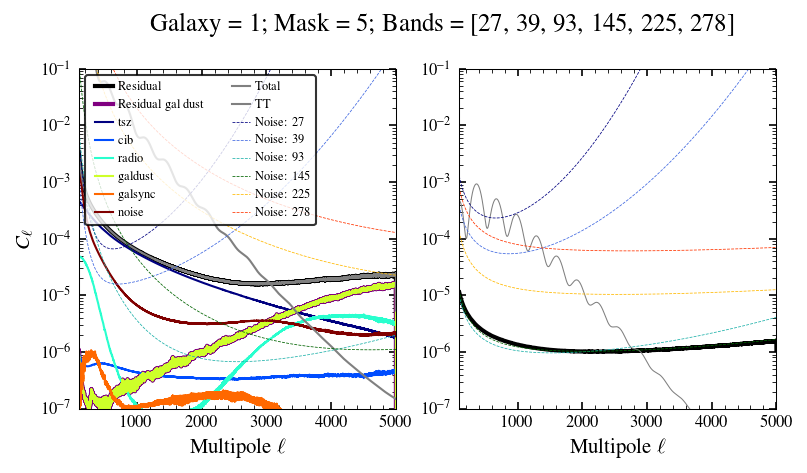

In [43]:
freq0, lmax = param_dict['freq0'], param_dict['lmax']
if include_gal:
    foregrounds_to_plot = ['kSZ', 'tSZ', 'DG-Po', 'DG-Cl', 'RG', 'dust', 'sync']
    pol_foregrounds_to_plot = ['dust', 'sync']
else:
    foregrounds_to_plot = ['kSZ', 'tSZ', 'DG-Po', 'DG-Cl', 'RG']
    pol_foregrounds_to_plot = []

#CAMB output for plotting
#camb_file = param_dict['Dlfile_len']
camb_file = '%s/%s' %(param_dict['data_folder'], param_dict['Dlfile_len'])
el_camb = np.loadtxt(camb_file, usecols = [0])
dl_camb = np.loadtxt(camb_file, usecols = [1,2,3,4])

cl_camb = ( Tcmb**2. * dl_camb * 2 * np.pi ) / ( el_camb[:,None] * (el_camb[:,None] + 1) )
cl_camb *= 1e12
cl_TT, cl_EE, cl_BB, cl_TE = cl_camb.T

clf(); 
fig = figure(figsize = (6,3))
fsval = 8
lwval = 0.75
plot_weights = 0
xmin, xmax = 100, 5000
if plot_weights:
    tr, tc = 6, len(which_spec_arr)
    subplots_adjust(wspace=0.1, hspace = 0.1)
    #first plot weights
    rspan, cspan = 2, 1
    curr_row = 0
    for cntr, which_spec in enumerate( which_spec_arr ):
        ax = subplot2grid((tr,tc), (curr_row, cntr), rowspan = rspan, colspan = cspan)#, xscale = 'log')#, yscale = 'log')
        if which_spec == 'TE':
            continue
            tot_teiter = 2
            for teiter in range(tot_teiter):
                if teiter == 0:
                    lsval = '-'
                else:
                    lsval = ':'
                shift = teiter * len(freqarr)
                for frqcntr, freq in enumerate( freqarr ):
                    #plot(weights_dic[which_spec][teiter][frqcntr], color = colordic[freq], label = r'%s' %(freq), lw = lwval, ls = lsval)
                    plot(weights_dic[which_spec][frqcntr+shift], color = colordic[freq], label = r'%s' %(freq), lw = lwval, ls = lsval)
                plot(np.sum(weights_dic[which_spec][teiter], axis = 0), 'k--', label = r'Sum', lw = lwval, ls = lsval)        
        else:
            for frqcntr, freq in enumerate( freqarr ):
                plot(weights_dic[which_spec][frqcntr], color = colordic[freq], label = r'%s' %(freq), lw = lwval)
            plot(np.sum(weights_dic[which_spec], axis = 0), 'k--', label = r'Sum', lw = lwval)
        axhline(lw=0.3);
        #xlabel(r'Multipole $\ell$');
        setp(ax.get_xticklabels(which = 'both'), visible=False)
        if cntr == 0:
            ylabel(r'Weight $W_{\ell}$')
            legend(loc = 1, fontsize = 5, ncol = 4, handlelength = 2., handletextpad = 0.1)
        else:
            setp(ax.get_yticklabels(which = 'both'), visible=False)
        ylim(-3., 3.);
        xlim(xmin, xmax);
        for label in ax.get_xticklabels(): label.set_fontsize(fsval)
        for label in ax.get_yticklabels(): label.set_fontsize(fsval)        

        title(r'%s' %(which_spec))#, fontsize = 10)

    curr_row = rspan
    rspan = tr - rspan
for cntr, which_spec in enumerate( which_spec_arr ):
    if plot_weights:
        #ax = subplot(1,2,cntr+1, xscale = 'log', yscale = 'log')
        ax = subplot2grid((tr,tc), (curr_row, cntr), rowspan = rspan, colspan = cspan, yscale = 'log', xscale = 'log')
    else:
        ax = subplot(1, len(which_spec_arr), cntr+1, yscale = 'log')#, xscale = 'log')
    plot(el, cl_residual[which_spec], 'black', lw = 2., label = r'Residual')
    if include_gal: #show gal residuals here as well
        if which_spec == 'TT':
            plot(el, fg_res_dic[which_spec]['galdust'], 'purple', lw = 2., label = r'Residual gal dust')
            #plot(el, fg_res_dic[which_spec]['galsync'], 'purple', lw = 2., label = r'Residual gal sync', alpha = 0.5)
    if which_spec == 'TT':
        tot = np.zeros(len(el))
        tmpcoloarr = [cm.jet(int(d)) for d in np.linspace(0, 255, len(signal_arr))]
        for scntr, s in enumerate( signal_arr ):
            plot(el, fg_res_dic[which_spec][s], lw = 1., label = r'%s' %(s), color = tmpcoloarr[scntr])
            tot += fg_res_dic[which_spec][s]
        plot(el, tot, lw = 1., label = r'Total', color = 'gray')
    if which_spec == 'TT':
        plot(el_camb, cl_TT, 'gray', lw = 1., label = r'TT')
        '''
        cl_fg = np.zeros(len(el))
        for curr_fg in foregrounds_to_plot:
            if curr_fg == 'dust':
                el, cl_curr_fg = fg.get_cl_galactic(param_dict, 'dust', 145, 145, 'TT', bl_dic = bl_dic, el = el)
            elif curr_fg == 'sync':
                el, cl_curr_fg = fg.get_cl_galactic(param_dict, 'sync', 145, 145, 'TT', bl_dic = bl_dic, el = el)
            else:
                el_, cl_curr_fg = fg.get_foreground_power_spt(curr_fg, freq1 = freq0, lmax = lmax)
            #plot(el, cl_curr_fg, lw = 0.5, ls = '--', label = r'150: %s' %(curr_fg), alpha = 0.4)
            cl_fg += cl_curr_fg
        plot(el, cl_fg, lw = 5., ls = '--', label = r'150: All foregrounds', alpha = 1.)
        '''
    elif which_spec == 'EE':
        plot(el_camb, cl_EE, 'gray', lw = 0.5)#, label = r'EE')
        '''
        for curr_fg in pol_foregrounds_to_plot:
            if curr_fg == 'dust':
                el, cl_curr_fg = fg.get_cl_galactic(param_dict, 'dust', 145, 145, 'EE', bl_dic = bl_dic, el = el)
            elif curr_fg == 'sync':
                el, cl_curr_fg = fg.get_cl_galactic(param_dict, 'sync', 145, 145, 'EE', bl_dic = bl_dic, el = el)
            plot(el, cl_curr_fg, lw = 0.5, ls = '--', label = r'150: %s' %(curr_fg), alpha = 0.4)
        '''
    elif which_spec == 'TE':
        plot(el_camb, cl_TE, 'gray', ls = '-', lw = 0.5)#, label = r'TE')        
        plot(el_camb, abs( cl_TE ), 'gray', ls = '--', lw = 0.5) 
        '''
        for curr_fg in pol_foregrounds_to_plot:
            if curr_fg == 'dust':
                el, cl_curr_fg = fg.get_cl_galactic(param_dict, 'dust', 145, 145, 'EE', bl_dic = bl_dic, el = el)
            elif curr_fg == 'sync':
                el, cl_curr_fg = fg.get_cl_galactic(param_dict, 'sync', 145, 145, 'EE', bl_dic = bl_dic, el = el)
            plot(el, cl_curr_fg, lw = 0.5, ls = '--', label = r'150: %s' %(curr_fg), alpha = 0.4)
        '''
    #for freq in freqarr:
    #    plot(el, cl_dic[which_spec][(freq,freq)], color = colordic[freq], lw = 0.5, ls = '-', label = r'%s' %(freq), alpha = 1.)        
    if (1):
        mv_comb_arr = []
        for freq in freqarr:
            if which_spec == 'TT':
                nl = nl_dic['T'][(freq, freq)]
            elif which_spec == 'EE':
                nl = nl_dic['P'][(freq, freq)]
            elif which_spec == 'TE':
                nl = nl_dic['T'][(freq, freq)] * 0.
            plot(el, nl, color = colordic[freq], lw = lwval*0.5, ls = '--', label = r'Noise: %s' %(freq))#, alpha = 0.5)
            mv_comb_arr.append(1./nl)
        mv_comb = 1./(np.sum(mv_comb_arr, axis = 0))
        ###plot(el, mv_comb, color = 'k', lw = 0.5, ls = '--', label = r'Noise: MV')
        #legend(loc=3, fancybox=1, ncol = 4, fontsize = 6);

    xlim(xmin, xmax);
    ylim(1e-7,1e-1);
    xlabel(r'Multipole $\ell$')
    if cntr == 0: 
        ylabel(r'$C_{\ell}$')
        legend(loc = 2, fontsize = 6, ncol = 2, handlelength = 2., handletextpad = 0.1)
    else:
        pass#setp(ax.get_yticklabels(which = 'both'), visible=False)
    for label in ax.get_xticklabels(): label.set_fontsize(fsval)
    for label in ax.get_yticklabels(): label.set_fontsize(fsval)
    
#tit = 'Galaxy = %s; Mask = %s; Bands = %s' %(include_gal, param_dict['which_gal_mask'], str(freqarr))
if remove_atm:
    tit = 'Galaxy = %s; Mask = %s; Bands = %s; no 1/f' %(include_gal, param_dict['which_gal_mask'], str(freqarr))
else:
    if include_gal:
        tit = 'Galaxy = %s; Mask = %s; Bands = %s' %(include_gal, param_dict['which_gal_mask'], str(freqarr))    
    else:
        tit = 'Bands = %s' %(str(freqarr))    
if (0):#not corr_noise:
    tit = '%s; No corr. noise' %(tit)
if cl_multiplier_dic is not None:
    if 'gal_dust' in cl_multiplier_dic:
        tit = r'%s (C$_{\ell}^{\rm gal, dust} \times %s$)' %(tit, cl_multiplier_dic['gal_dust'])
suptitle(r'%s' %tit, x = 0.53, y = 1.)
savefig(plname)
print(plname)

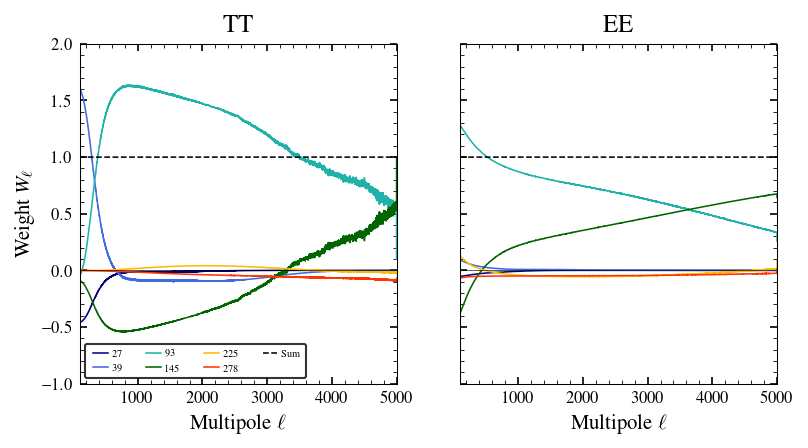

In [44]:
#first plot weights
fig = figure(figsize = (6,3))
rspan, cspan = 2, 1
curr_row = 0
for cntr, which_spec in enumerate( which_spec_arr ):
    ax = subplot(1,2,cntr+1)#, xscale = 'log')#, yscale = 'log')
    if which_spec == 'TE':
        continue
        tot_teiter = 2
        for teiter in range(tot_teiter):
            if teiter == 0:
                lsval = '-'
            else:
                lsval = ':'
            shift = teiter * len(freqarr)
            for frqcntr, freq in enumerate( freqarr ):
                #plot(weights_dic[which_spec][teiter][frqcntr], color = colordic[freq], label = r'%s' %(freq), lw = lwval, ls = lsval)
                plot(weights_dic[which_spec][frqcntr+shift], color = colordic[freq], label = r'%s' %(freq), lw = lwval, ls = lsval)
            plot(np.sum(weights_dic[which_spec][teiter], axis = 0), 'k--', label = r'Sum', lw = lwval, ls = lsval)        
    else:
        for frqcntr, freq in enumerate( freqarr ):
            plot(weights_dic[which_spec][frqcntr], color = colordic[freq], label = r'%s' %(freq), lw = lwval)
        plot(np.sum(weights_dic[which_spec], axis = 0), 'k--', label = r'Sum', lw = lwval)
    axhline(lw=0.3);
    xlabel(r'Multipole $\ell$');
    #setp(ax.get_xticklabels(which = 'both'), visible=False)
    if cntr == 0:
        ylabel(r'Weight $W_{\ell}$')
        legend(loc = 3, fontsize = 5, ncol = 4, handlelength = 2., handletextpad = 0.1)
    else:
        setp(ax.get_yticklabels(which = 'both'), visible=False)
    ylim(-1., 2.);
    xlim(xmin, xmax);
    for label in ax.get_xticklabels(): label.set_fontsize(fsval)
    for label in ax.get_yticklabels(): label.set_fontsize(fsval)        

    title(r'%s' %(which_spec))#, fontsize = 10)


In [45]:
if (1): #save residual files
    cl_gal_dic_dust_fname = param_dict['cl_gal_dic_dust_fname']
    try:
        cl_gal_folder = param_dict['cl_gal_folder']
        cl_gal_dic_dust_fname = '%s/%s' %(cl_gal_folder, cl_gal_dic_dust_fname)
    except:
        pass
    print(cl_gal_dic_dust_fname)
    galdustsims_cl = np.load(cl_gal_dic_dust_fname, allow_pickle=1, encoding = 'latin1').item()
    if not include_gal:
        fsky_val = 0.68
    else:
        fsky_val = galdustsims_cl['fsky_arr'][param_dict['which_gal_mask']]
    opdic = {}
    opdic['el'] = el
    if cl_multiplier_dic is not None:
        opdic['cl_multiplier_dic'] = cl_multiplier_dic
    opdic['cl_residual'] = cl_residual
    opdic['fg_res_dic'] = fg_res_dic
    opdic['freqcalib_fac'] = freqcalib_fac
    opdic['param_dict'] = param_dict
    opdic['fsky_val'] = fsky_val
    opdic['which_gal_mask'] = which_gal_mask
    opdic['weights'] = weights_dic
    #opdic['nl_dic'] = nl_dic
    opdic['beam_noise_dic'] = beam_noise_dic
    opdic['elknee_dic'] = elknee_dic
    np.save(opfname, opdic)
    print(opfname)

/Volumes/data_PHD_WD_babbloo/s4/cmbs4/map_based_simulations/202102_design_tool_input/4096//dust/0000/s4like_mask_v2/cls_galactic_sims_dust_nside2048_lmax5000_cos_el_40.npy
results/20210423_with202102designtoolinputforpySM3sims/s4like_mask_v2/TT-EE/baseline//s4wide_ilc_galaxy1_27-39-93-145-225-278_TT-EE_galmask5_AZ_for7years.npy
